# FCAL Simulation Single Dimension Time Series Test

This is a test of the LSTM mechanism by fitting a single gain (g17) using only that same gain as input. This should be a very basic problem where the predicted variable is not hidden like in the more complex $\alpha$ tests.


Cell completed at: 2023-09-07 20:59:57.935716


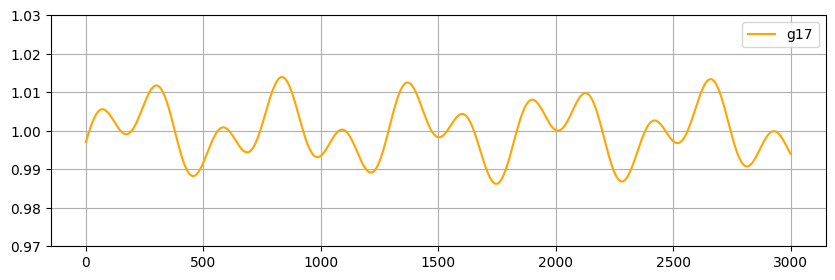

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.set_floatx('float64')

version = 7
filename = f'fcal_DLv{version}.csv'

df = pd.read_csv(filename)

df.plot(y=["g17"], color=["orange"], kind="line", grid=True, ylim=(0.97, 1.03),figsize=(10,3))

print("Cell completed at:", datetime.datetime.now())

## Prepare training and validation sets

This will split the data into training and validation sets. 

In [2]:
split_fraction = 0.70
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 200   # number of timesteps in the past to use for predicting value(s) for current timestep
future = 0   # number of timesteps in the future to predict value for
learning_rate = 0.002
batch_size = 100
epochs = 5000

df_train = df[:train_split-1]
df_valid = df[train_split:]
df_train_labels = df[:train_split-1]
df_valid_labels = df[train_split:]

# Chop off ends so we have a full set of past elements and corresponding future
g17_train = df_train["g17"].values
g17_valid = df_valid["g17"].values
x_train = g17_train[:-1]
y_train = g17_train[past:]
x_valid = g17_valid[:-1]
y_valid = g17_valid[past:]
print("x_train shape: "+str(x_train.shape) + "   y_train shape: "+str(y_train.shape))
print("x_valid shape: "+str(x_valid.shape) + "   y_valid shape: "+str(y_valid.shape))


x_train shape: (2098,)   y_train shape: (1899,)
x_valid shape: (899,)   y_valid shape: (700,)


### Create Timeseries datasets

This creates datasets in a form that can be easily used for training. Note that we use overlapping points. E.g. time steps 0-199 are used to predict $g17_{200}$, time steps 1-200 are used to predict $g17_{201}$, etc...

The labels ("y"s defined in the cell above) start with the first predicted value. E.g. y_train[0] = $g17_{200}$, y_train[1] = $g17_{201}$, ...

In [3]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
    shuffle=True,
)

for batch in  dataset_train.take(1): train_inputs, train_targets = batch
print("  Training: Input shape:", train_inputs.numpy().shape, " Target shape:" , train_targets.numpy().shape)

dataset_valid = keras.preprocessing.timeseries_dataset_from_array(
    x_valid,
    y_valid,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
    shuffle=True,
)

for batch in  dataset_valid.take(1): valid_inputs, valid_targets = batch
print("Validation: Input shape:", valid_inputs.numpy().shape, " Target shape:" , valid_targets.numpy().shape)



  Training: Input shape: (100, 200)  Target shape: (100,)
Validation: Input shape: (100, 200)  Target shape: (100,)


## Create Model

This creates an LSTM model for predicting the next point in the sequence.

In [4]:

inputs = keras.layers.Input(shape=(train_inputs.shape[1], 1))

# Residual for corrected alpha
lstm_out = keras.layers.LSTM(64, activation="linear", return_sequences=False, recurrent_activation="tanh")(inputs)
# lstm_out = keras.layers.Dropout(rate=0.05, noise_shape=(None,1,1))(lstm_out)
# lstm_out = keras.layers.LSTM(64, activation="tanh", return_sequences=True, recurrent_activation="tanh")(lstm_out)
# lstm_out = keras.layers.LSTM(64, activation="tanh", recurrent_activation="tanh")(lstm_out)
outputs = keras.layers.Dense(1, activation="linear")(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate*10.0, clipvalue=0.5), loss="mse")
model.summary()

import datetime

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (132.51 KB)
Trainable params: 16961 (132.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit Model 

Use early stopping and save the best model to a _.h5_ file.

In [5]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
    callbacks=[es_callback,reduce_lr],
)

print("Cell completed at:", datetime.datetime.now())

Epoch 1/5000
19/19 [==============================] - 3s 141ms/step - loss: 270433422027775619951477449372658666815736872821992943072569720591213395968.0000 - val_loss: 0.0042 - lr: 0.0200
Epoch 2/5000
19/19 [==============================] - 3s 143ms/step - loss: 8377057163411209293489621829328065073408188634555835395147506485559296.0000 - val_loss: 0.0415 - lr: 0.0200
Epoch 3/5000
19/19 [==============================] - 3s 145ms/step - loss: 0.0118 - val_loss: 2.3664e-04 - lr: 0.0200
Epoch 4/5000
19/19 [==============================] - 3s 144ms/step - loss: 0.0069 - val_loss: 0.0012 - lr: 0.0200
Epoch 5/5000
19/19 [==============================] - 3s 147ms/step - loss: 3.6448e-04 - val_loss: 3.1527e-05 - lr: 0.0200
Epoch 6/5000
19/19 [==============================] - 3s 146ms/step - loss: 5.3086e-05 - val_loss: 2.5062e-05 - lr: 0.0200
Epoch 7/5000
19/19 [==============================] - 3s 148ms/step - loss: 2.8265e-05 - val_loss: 1.8599e-05 - lr: 0.0200
Epoch 8/5000
19/19 [====

### Loss Function Model

n.b. This is plotted on a log scale

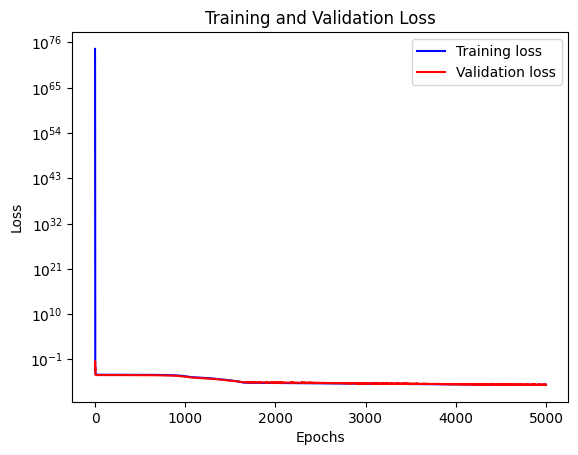

In [6]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

## Results

The following cell performs inference on the entire dataset (training and validation). The results are stored in the original dataframe as column "g17_model".

In [7]:
# Create overlapping windows of data
x_all = df["g17"].values
num_windows = x_all.shape[0] - past
print("x_all shape:" + str(x_all.shape) + f"  num_windows={num_windows}")
windows = np.lib.stride_tricks.sliding_window_view(x_all, (past))

df['g17_model'] = np.nan

# Predict using batches and update df
batch_size_ = 32
for i in range(0, num_windows, batch_size_):
    batch_windows = windows[i:i+batch_size_]
     # Reshape batch_windows to match the model's input shape
    batch_windows_reshaped = np.reshape(batch_windows, (batch_windows.shape[0], past))
    y_pred_batch = model.predict(batch_windows_reshaped, verbose=0)
    y_pred_batch_flattened = y_pred_batch.flatten()
    this_batch_size = batch_windows.shape[0]
    df.loc[i+past-1:i+this_batch_size+past-1-1, 'g17_model'] = y_pred_batch_flattened
    print("\rprocessed: {}/{}".format(i, num_windows), end="")

print("\rprocessed: {}/{}".format(num_windows, num_windows), end="")

x_all shape:(3000,)  num_windows=2800
processed: 2800/2800

# g17 Model vs Truth

The top plot below shows the true $g17$ and the one predicted by the model. Since the model requires 200 past timesteps, its predictions are only available for timestep 200 and later.

The bottom plot shows the error (residual) bewtween $g17$ and the model prediction.

<Axes: >

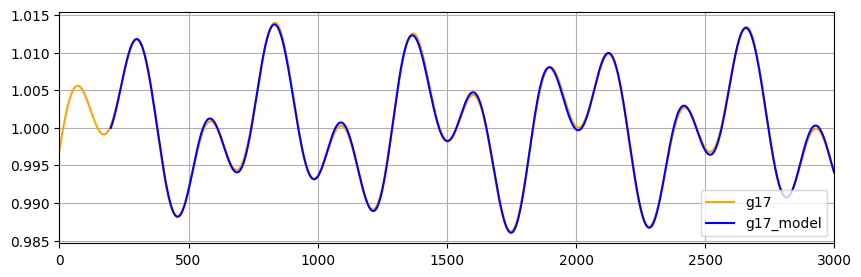

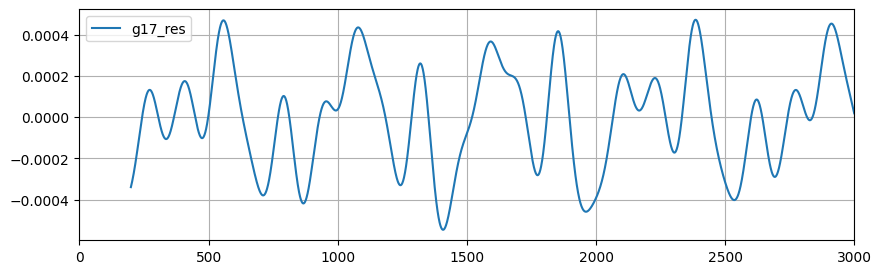

In [8]:
df.plot(y=["g17", "g17_model"], color=["orange", "blue"], kind="line", grid=True, xlim=[0,3000],figsize=(10,3))

df["g17_res"] = df["g17_model"] - df["g17"]
df.plot(y=["g17_res"], kind="line", grid=True, xlim=[0,3000], figsize=(10,3))

# Basement
<hr>

### Example predictions

Plot a few examples showing the $\alpha$ truth history and the model prediction. This is also carried over from the keras weather example. The red "X" is just the last point in the truth history since here, we are not trying to predict the future, only use the past to predict the present.

n.b. Unlike the original example for the weather which included Temperature in the features and was used to predict Temperature in the future, this problem does not directly measure $\alpha$. Thus these blue points are useful to guide the human eye, but are not values the model sees.

The first 3 plots are from the validation set while the second three are from the training set.

In [ ]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future_ = delta
    else:
        future_ = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future_, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend(loc="upper left")
    plt.xlim([time_steps[0], (future_ + 5) * 2])
    plt.ylim([0.90, 1.10])
    plt.xlabel("Time-Step")
    plt.show()
    return

# This has the alpha history with last point being the same as the label
# alpha_valid = df_valid_labels.filter(items=["alpha"])[:-(past+future)].values
# alpha_train = df_train_labels.filter(items=["alpha"])[:-(past+future)].values

 
# Validation examples
for i in range(3):
    start = i*62
    x = np.expand_dims(x_valid[start:start+past], 0)
    y_history = x[:-1]
    y_true = y_history[-1]
    y_pred = model.predict(x)
    show_plot(  [y_history, y_true, y_pred], 0, "Example from Validation Set")

# Training examples
for i in range(3):
    start = i*62
    x = np.expand_dims(x_train[start:start+past], 0)
    y_history = x[:-1]
    y_true = y_history[-1]
    y_pred = model.predict(x)
    show_plot(  [y_history, y_true, y_pred], 0, "Example from training Set")
